In [0]:
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)
comments = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments")
submissions = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions")

#Check the data

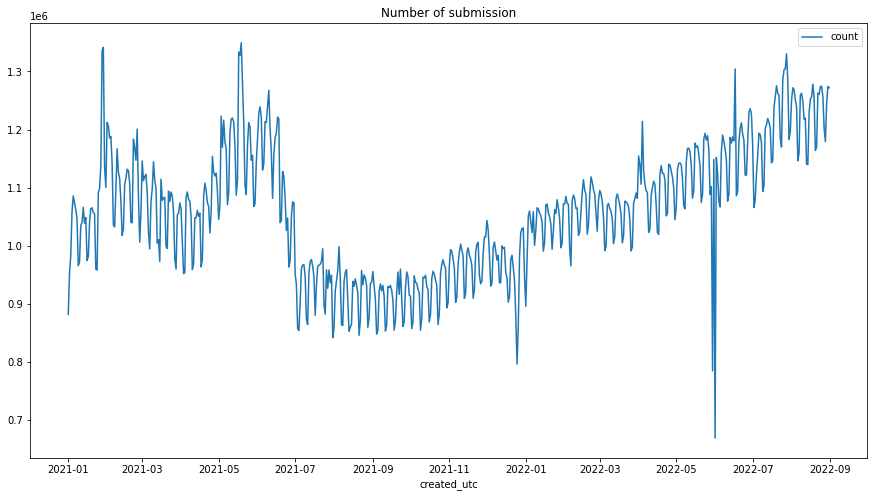

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-198060461897581> in <cell line: 6>()
      4 time_count = time_submission.groupBy('created_utc').count().orderBy(col('created_utc')).toPandas()
      5 time_count.plot.line(x="created_utc", y="count", figsize=(15,8), title='Number of submission')
----> 6 plt.show()

NameError: name 'plt' is not defined

In [0]:
from pyspark.sql.functions import *
time_submission = submissions.withColumn("created_utc", from_unixtime(col("created_utc"),"MM-dd-yyyy"))
time_submission = time_submission.withColumn("created_utc",to_date(col("created_utc"),"MM-dd-yyyy"))
time_count = time_submission.groupBy('created_utc').count().orderBy(col('created_utc')).toPandas()
time_count.plot.line(x="created_utc", y="count", figsize=(15,8), title='Number of submission')
plt.show()

#Feature engineering

In [0]:
import numpy as np
import pandas as pd
for i in range(1,6):
    time_count["T_" + str(i)] = time_count["count"].shift(i)
time_count.fillna(0.0, inplace=True)


In [0]:
time_count.reset_index(inplace=True)
time_count = time_count.rename(columns = {'index':'day_index'})

In [0]:
# split data and label for train and validation
train_df = time_count[:-50]
val_df = time_count[-50:]
x_train, y_train = train_df.drop(["count","created_utc"],axis=1),train_df["count"]
x_test, y_test = val_df.drop(["count","created_utc"],axis=1),val_df["count"]

#Ramdom Forest

In [0]:
#random forest
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

#fit model
regr = RandomForestRegressor(n_estimators=20, max_depth=5, random_state=0)
regr.fit(x_train, y_train)
joblib.dump(regr, "TS_RF.pkl") 
train_pred = regr.predict(x_train)
y_pre = regr.predict(x_test)
#check the rmse
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, y_pre)))

Validation rmse: 76802.56761185802


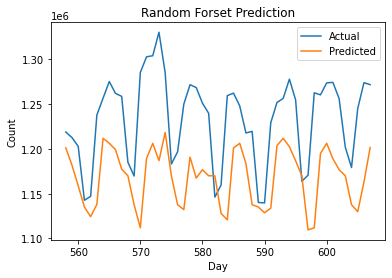

In [0]:
import matplotlib.pyplot as plt
import numpy as np
#draw the trend
fig, ax = plt.subplots()
ax.plot(x_test['day_index'], y_test, label='Actual')
ax.plot(x_test['day_index'], y_pre, label='Predicted')
plt.title('Random Forset Prediction')
plt.xlabel('Day')
plt.ylabel('Count')
ax.legend()
plot_fpath = os.path.join(PLOT_DIR, 'TS_RF_Prediction.png')
plt.savefig(plot_fpath)
plt.show()

#Support Vector Machine

In [0]:
#svm
from sklearn import svm

#fit model
clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)
joblib.dump(regr, "TS_SVM.pkl") 
train_pred = clf.predict(x_train)
y_pre = clf.predict(x_test)
#check the rmse
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, y_pre)))

Validation rmse: 89291.73667859753


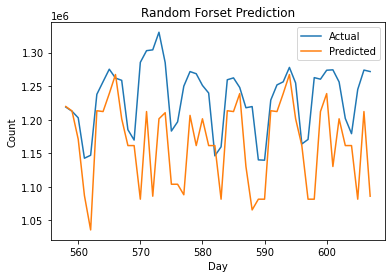

In [0]:
#draw the trend
fig, ax = plt.subplots()
ax.plot(x_test['day_index'], y_test, label='Actual')
ax.plot(x_test['day_index'], y_pre, label='Predicted')
plt.title('Random Forset Prediction')
plt.xlabel('Day')
plt.ylabel('Count')
ax.legend()
plot_fpath = os.path.join(PLOT_DIR, 'TS_SVM_Prediction.png')
plt.savefig(plot_fpath)
plt.show()

#Tuning for RF

In [0]:
#fit model
t_rmse = []
v_rmse = []

for i in range(5, 100):
    regr = RandomForestRegressor(n_estimators=10, max_depth=i, random_state=0)
    regr.fit(x_train, y_train)
    train_pred = regr.predict(x_train)
    y_pre = regr.predict(x_test)
    #check the rmse
    t_rmse.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    v_rmse.append(np.sqrt(mean_squared_error(y_test, y_pre)))

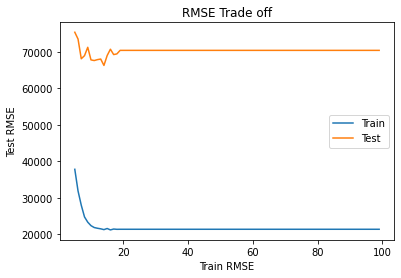

In [0]:
#draw the trend
fig, ax = plt.subplots()
x = range(5, 100)
ax.plot(x, t_rmse, label='Train')
ax.plot(x, v_rmse, label='Test')
plt.title('RMSE Trade off')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
ax.legend()
plot_fpath = os.path.join(PLOT_DIR, 'RMSE_Tradeoff.png')
plt.savefig(plot_fpath)
plt.show()

In [0]:
regr = RandomForestRegressor(n_estimators=10, max_depth=15, random_state=0)
regr.fit(x_train, y_train)
joblib.dump(regr, "TS_RF_OPTED.pkl") 
train_pred = regr.predict(x_train)
y_pre = regr.predict(x_test)
#check the rmse
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, y_pre)))

Validation rmse: 68995.39979931254


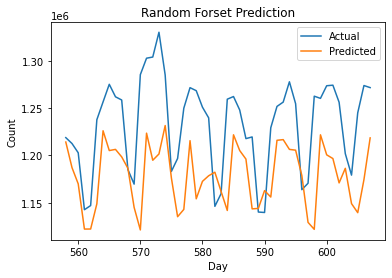

In [0]:
#draw the trend
fig, ax = plt.subplots()
ax.plot(x_test['day_index'], y_test, label='Actual')
ax.plot(x_test['day_index'], y_pre, label='Predicted')
plt.title('Random Forset Prediction')
plt.xlabel('Day')
plt.ylabel('Count')
ax.legend()
plot_fpath = os.path.join(PLOT_DIR, 'TS_RF_Prediction_Opted.png')
plt.savefig(plot_fpath)
plt.show()